# Welcome to OpenVINO(TM) Hands-on Lab Session 3 - Advanced Features

In this tutorial, we will look at some of the advanced featues of Intel(R) Distribution of OpenVINO(TM) to help you get performance upgrades, using multiple target devices at the same time, creating custom layers and configuring execution of layers manually on different hardware devices.

Jupyter notebook is a browser based IDE and allows partial code executions and text based inputs as markdown at each cell.

Please follow the notations for each instruction in the following sections:

- If tutorial wants you run a certain command on terminal you will see the text as below. You should open a terminal or continue on the opened one as instructed. 

**Commands To Run on Terminal**
***
```bash
python3 
```
***

In Ubuntu, when you copy text, easiest way to paste code with keyboard is to press:

**SHIFT + INS** buttons

- If there are text looks like code; it is mainly the output of an example run of a sample code, please don't copy those back into terminal. 

**Example Terminal Output** 
***
``` output ```
***

- If you see python code inside the cell like below, take focus to cell by clicking to it then press:

**SHIFT + ENTER** 

or Click on `>| Run` run button above.

Below example is a code block, which you can run inside this browser session and see the output directly below the cell. You don't need to copy the code to terminal or any other IDE.

In [1]:
import numpy as np

arr1 = np.zeros(5)
print('Array 1 ', arr1)

arr2 = np.ones(5)
print('Array 2', arr2)

# Array Product 
print(arr1 * arr2)

Array 1  [0. 0. 0. 0. 0.]
Array 2 [1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0.]


# Agenda

## Part 1 - Inference Engine - Heterogeneous Plugin
At this section we will run Inference Engine Heterogeneous Plugin code samples inside Jupyter Notebook to see how Heterogeneous Plugin runs on heterogeneous hardware environments. 

## Part 2 - Inference Engine - Layer Affinity
This part is a follow-up of Heterogeneous Plugin which shows how manual configuration be applied to DL layer assignment to HW devices.

## Part 3 - Inference Engine - Performance Counters
Another feature of Inference Engine will be seen at this part to see performance metrics of layer executions.


## Part 4 - Custom Layers
Custom layers are NN (Neural Network) layers that are not explicitly supported by a given framework. This tutorial demonstrates how to run inference on topologies featuring custom layers allowing you to plug in your own implementation for existing or completely new layers.

# Part 1: Intel(R) Distribution of OpenVINO(TM) : Heterogenous Plugin

At this session, we would like to go over more detailed explanation of OpenVINO(TM) Toolkit Inference Engine's Heterogeneous API which helps to run inference on heterogeneous platforms. 

If you are running on a platform with Intel CPU and GPU, you can control what layers of Deep Learning Model would be running on the selected hardware platform. 

Heterogeneous API has been developed first with fallback principle, it means whenever a deep learning layer not implemented for target platform it should fallback to CPU, which can execute all layers.  

Not all layer's implementations are complete for each platform and certain layers can execute a lot faster on different platforms where some can't. As such, there has been great progress over the heterogeneous API use cases for Inference to analyze the performance bottlenecks and improve the inference process. 

At this section, we want to showcase its use on object detection scenario and get detailed analysis of executions of layers on devices a quick course of Heterogeneous Plugin of Intel(R) Distribution of OpenVINO(TM) Toolkit.   

## 1 - Load Libraries & Implement Helper Methods

As in all previous sections, we again use `createNetwork`, `loadNetwork` and `prerocessImage` method before implementing inference with heterogeneous plugin.

#### Change Focus to Below Cell and Press (SHIFT + ENTER) or Click on Run Button

In [2]:
# Let's Import Required Libraries first
import sys
import os
import time
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Import OpenVINO
from openvino.inference_engine import IENetwork, IEPlugin

# For labeling the image after inference.
from utils.out_process import placeBoxes

# Define Methods

def createNetwork(model_xml, model_bin, plugin):
    # Importing network weights from IR models.
    net = IENetwork(model=model_xml, weights=model_bin)
        
    return net

def loadNetwork(plugin, net, num_requests=2):
    # Loading IR model to the plugin.
    exec_net = plugin.load(network=net, num_requests=num_requests)
    
    # Getting the input and outputs of the network
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    
    return exec_net,input_blob,out_blob

def preprocessImage(img_path, net, input_blob):
    # Reading the frame from a jpeg file
    frame = cv.imread(img_path)
    
    # Reshaping data
    n, c, h, w = net.inputs[input_blob].shape
    in_frame = cv.resize(frame, (w, h))
    in_frame = in_frame.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    
    return in_frame.reshape((n, c, h, w)),frame

print('SUCCESS')

SUCCESS


At this part, we are implementing a new inference method which is working with heterogeneous plugin. 

There are couple more steps we have added to inference process.

- First we check if there is a CPU device on the list of devices, we load cpu extensions library.

- Then, we load the network as usual process. 

-  `set_config` function configures the plugin fallback devices and their order.

Heterogeneous Plugin used with `HETERO:` prefix, which is followed with a list of devices, according to their prioritization. 

- After network load, we send the network to plugin to set affinity of layers according to priority list we give to plugin. When affinity sets the layer's target device to be executed.

- Additionally we have performance counters or certain outputs we can later analyze the network. `.set_config({"HETERO_DUMP_GRAPH_DOT": "YES"})` prints .dot output which has a detailed graph representation of model. 

- Finally, `get_perf_counts` method prints the detailed execution times of layers on the devices.

Let's run the next cell and make `runInference` method ready.

## 2 - Implement New `runInference` Method

In this implementation we will do as defined in previous part. If you examine the code you will see the steps as following:

- Load Plugin, set `device` parameter with 'HETERO:GPU,CPU` 

- Then parse plugin string to check if any extention is required. 

- Create network

- Set Configurations: 
    - `TARGET_FALLBACK`
    
    - `HETERO_DUMP_GRAPH_DOT` to output graph output.
    
- Generate Executable Network and Run Inference

- At the end of the script, if enabled prints `performance counters` values. 

#### Change Focus to Below Cell and Press (SHIFT + ENTER) or Click on Run Button

In [3]:
# At this stage we implement our inference method to run with Heterogeneous plugin. 

def runInference(hetero_device = 'HETERO:GPU,CPU',
                 model_xml='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP32/mobilenet-ssd.xml',
                 model_bin='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP32/mobilenet-ssd.bin',
                 image_file='images/car.png',
                 performance_counters = False,
                 dot_graph = True,
                 confidence_threshold=0.6):

    # Plugin initialization for specified device. We will be targeting CPU initially.
    plugin = IEPlugin(device=hetero_device, plugin_dirs='/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64')
    
    # Heterogeneous Plugin is provided as
    #HETERO:GPU,CPU or similar.
    vals = hetero_device.split(':')
    targets = vals[1].split(',')
    
    # Let's check if heterogeneous plugin has CPU target so we can add cpu extensions
    # Loading additional exension libraries for the CPU
    if hetero_device == 'CPU' or ('CPU' in targets):
        extension_list=['/home/intel/inference_engine_samples_build/intel64/Release/lib/libcpu_extension.so']
        for extension in extension_list:
            plugin.add_cpu_extension(extension)
 
    net = createNetwork(model_xml, model_bin, plugin)
    
     # Let's check if the target is heterogeneous then we add fallback device priorities
     #If we set TARGET_FALLBACK configuration, we want IE to decide what device to fallback. 
    
    plugin.set_initial_affinity(net)
    plugin.set_config({"TARGET_FALLBACK": hetero_device})
    
    if dot_graph:
        # Just for a show case, remove
        plugin.set_config({"HETERO_DUMP_GRAPH_DOT": "YES"})
    
    exec_net, input_blob, out_blob = loadNetwork(plugin, net)
    
    in_frame,original_frame = preprocessImage(image_file, net, input_blob)

    my_request_id = 0

        # Starting the inference in async mode, which starts the inference in parallel
    inference_start = time.time()
    exec_net.start_async(request_id=my_request_id, inputs={input_blob: in_frame})
    # ... You can do additional processing or latency masking while we wait ...

    # Blocking wait for a particular request_id
    if exec_net.requests[my_request_id].wait(-1) == 0:
        # getting the result of the network
        res = exec_net.requests[my_request_id].outputs[out_blob]
        inference_end = time.time()
        # Processing the output result and adding labels on the image. Implementation is not shown in the
        #  this notebook; you can find it in object_detection_demo_ssd_async.py
        initial_w = original_frame.shape[1]
        initial_h = original_frame.shape[0]

        frame = placeBoxes(res, None, confidence_threshold, original_frame, initial_w, initial_h, False, my_request_id, ((inference_end - inference_start)))
        # We use pyplot because it plays nicer with Jupyter Notebooks
        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111)
        ax.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB), interpolation='none')
        plt.axis("off")
        plt.show()
    else:
        print("There was an error with the request")
    
    if performance_counters:
        perf_counts = exec_net.requests[0].get_perf_counts()
        print("Performance counters:")
        for layer, stats in perf_counts.items():
            print(layer, ': ', stats)
    
    return (plugin, net, exec_net)

print('SUCCESS')

SUCCESS


In next cell, I would like to use Heterogeneous plugin to run object detection sample. 

With `HETERO:GPU,CPU,MYRIAD` we indicate to our plugin to prioritize `GPU > CPU > MYRIAD` for layers to be executed. 

For MobileNet-SSD example, almost all layers can run on GPU except `PriorBox` Caffe layer. Therefore, it will use GPU for all the `Convolution` layers and CPU for PriorBox layer.

If, we have been used `HETERO:GPU,MYRIAD,CPU` , `PriorBox` layer would be running on MYRIAD since it has also support for it. 

Note that, we use FP16 because, in case CPU target is being used, IE helps to convert FP16 layers to FP32 automatically.  

## 3 - Run Inference

#### Change Focus to Below Cell and Press (SHIFT + ENTER) or Click on Run Button

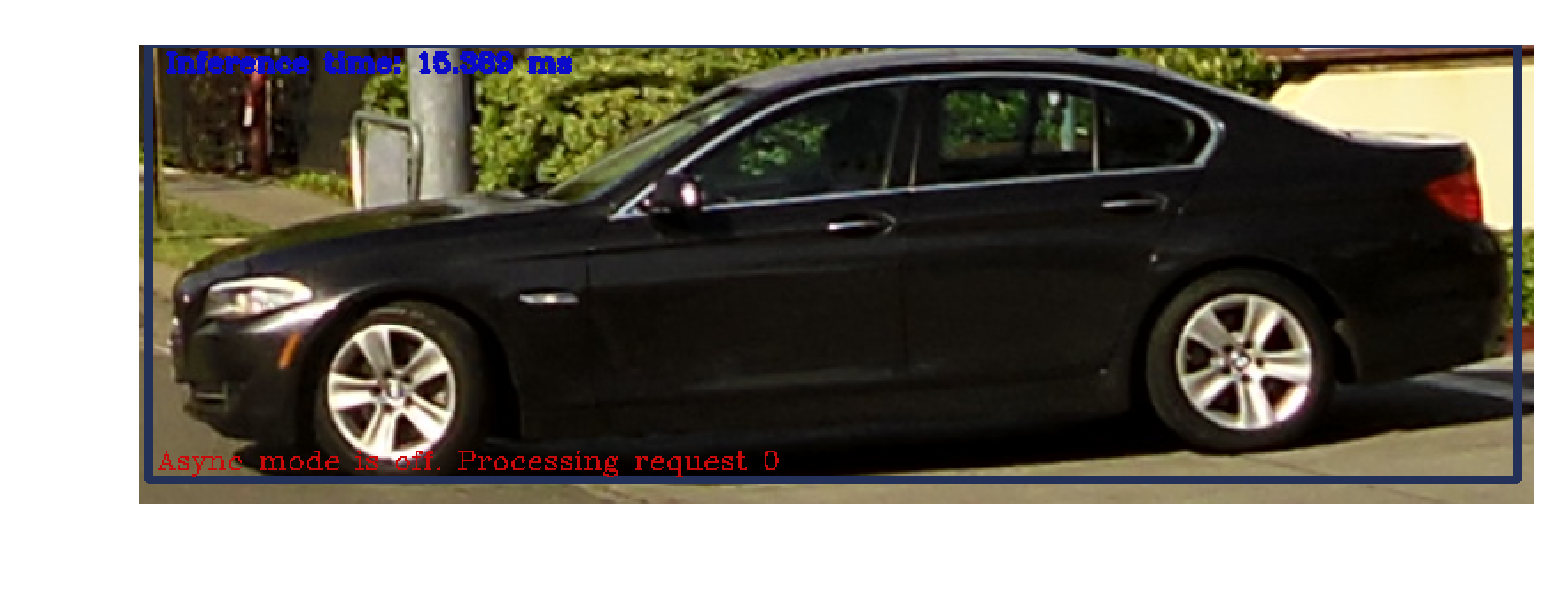

In [4]:
# Run code with : (SHIFT + ENTER) or Press Run Button #

hetero_objects = runInference(hetero_device = 'HETERO:GPU,CPU',
                              model_xml='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP16/mobilenet-ssd.xml',
                              model_bin='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP16/mobilenet-ssd.bin',
                              image_file='images/car.png',
                              performance_counters = False)

Running principles of Hetergeneous plugin is simple but if you want to take all the advantages of process and manually change the running layers and their target layers you should use layer affinity feature the change the execution target device.

# Part 2: Layer Affinity

Affinity by meaning likeness so you can image like a linkage of layer to target device. 

In this part we will look at how we can use this feature with Python API.

This is a simple output of below code showing layer's affinity.

```
Type:  Input Device:  CPU
Type:  ScaleShift Device:  GPU
Type:  Convolution Device:  GPU
```

## 1 - Print Layer Affinities of Previous Section. 

Below part reads IE network object and prints the network layer values. 

**Note**: Please make sure you already run the previous part.

#### Change Focus to Below Cell and Press (SHIFT + ENTER) or Click on Run Button

In [5]:
net = hetero_objects[1]

for l in net.layers.values():
    print('Type: ', l.type, 'Device: ', l.affinity)

Type:  Input Device:  CPU
Type:  ScaleShift Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU
Type:  ReLU Device:  GPU
Type:  Convolution Device:  GPU

`{"HETERO_DUMP_GRAPH_DOT": "YES"}` configuraion let's us to print the network visualisation in .dot graph format. You can navigate to current directory and run it as below from a new terminal.


```bash
!xdot hetero_affinity_MobileNet-SSD.dot
```

![Dot Output](images/affinity_dot.png)

## 2 - Change Priority in Heterogeneous Plugin

Let's use CPU First

#### Change Focus to Below Cell and Press (SHIFT + ENTER) or Click on Run Button

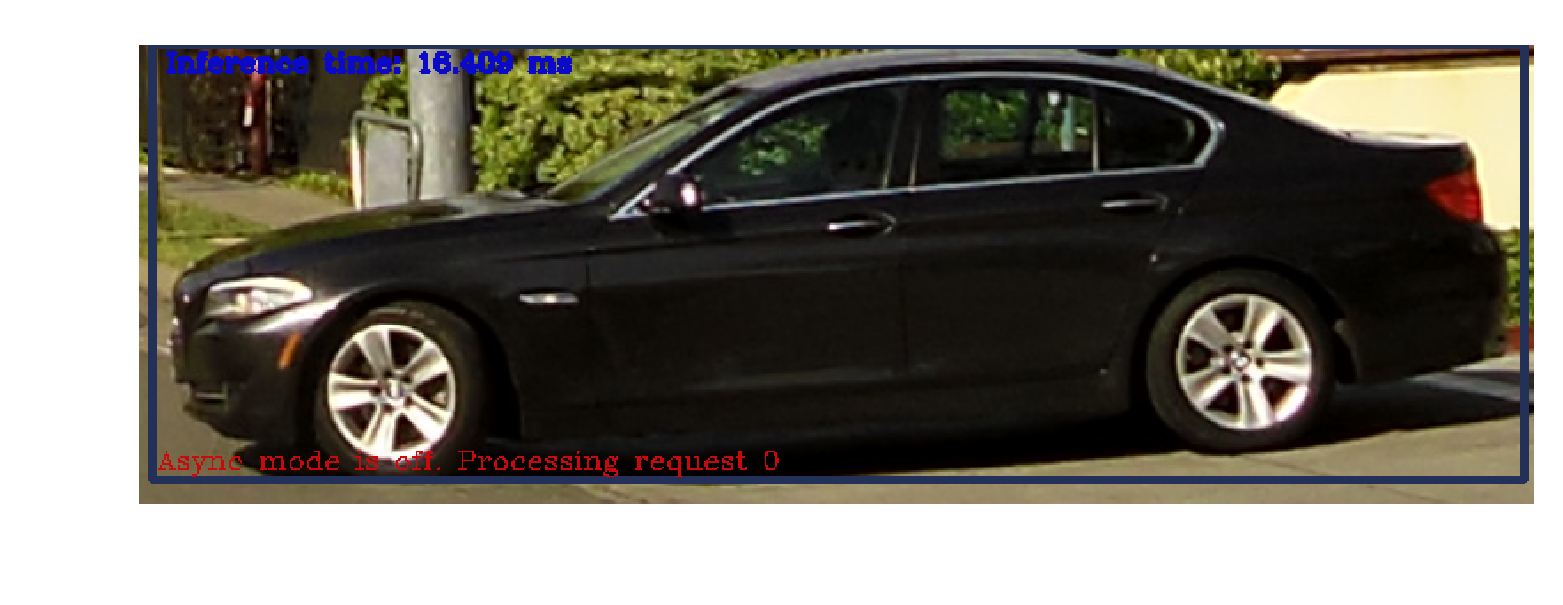

In [6]:
hetero_objects = runInference(hetero_device = 'HETERO:CPU,GPU',
                              model_xml='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP16/mobilenet-ssd.xml',
                              model_bin='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP16/mobilenet-ssd.bin',
                              image_file='images/car.png',
                              performance_counters = False)

## 3 - Let's Check Layer Affinities 

You will notice that all layers assigned to CPU now.

#### Change Focus to Below Cell and Press (SHIFT + ENTER) or Click on Run Button

In [7]:
net = hetero_objects[1]

for l in net.layers.values():
    print('Type: ', l.type, 'Device: ', l.affinity)

Type:  Input Device:  CPU
Type:  ScaleShift Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU
Type:  ReLU Device:  CPU
Type:  Convolution Device:  CPU

## 4 - Let's Try with Myriad 


#### Change Focus to Below Cell and Press (SHIFT + ENTER) or Click on Run Button

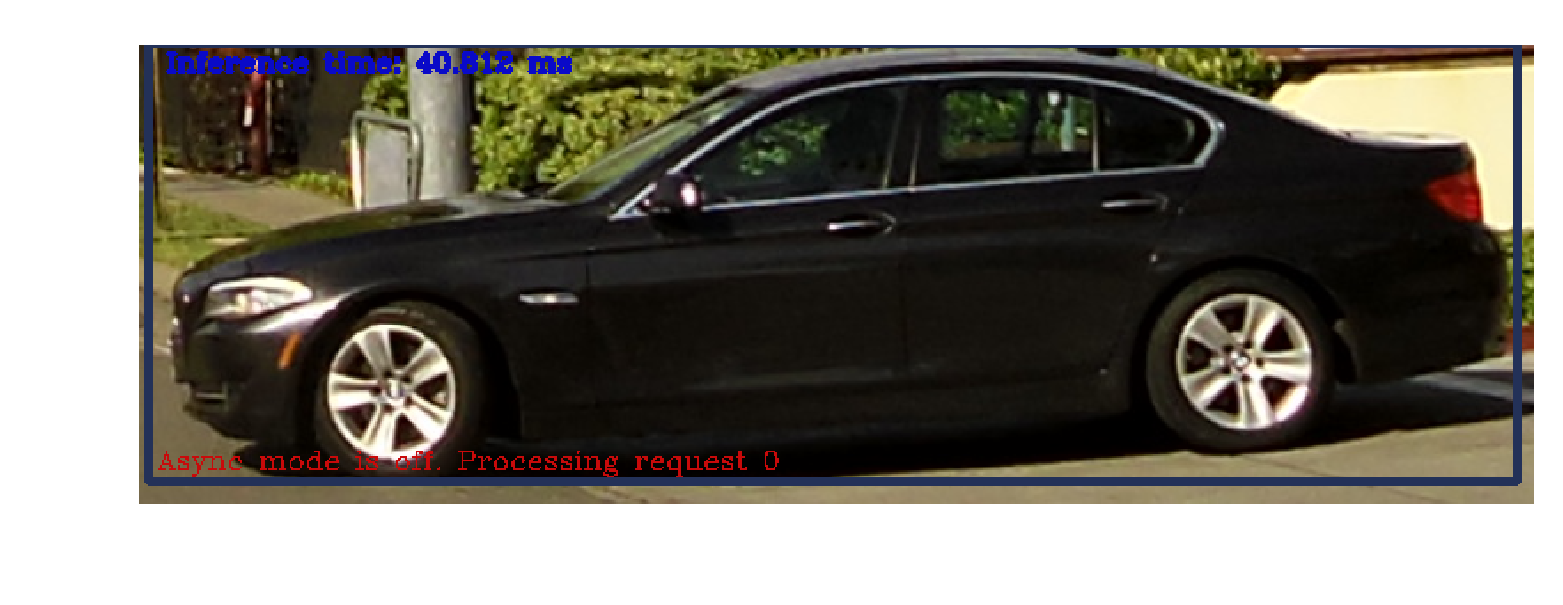

Type:  Input Device:  CPU
Type:  ScaleShift Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MYRIAD
Type:  Convolution Device:  MYRIAD
Type:  ReLU Device:  MY

In [8]:
hetero_objects = runInference(hetero_device = 'HETERO:MYRIAD,GPU,CPU',
                              model_xml='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP16/mobilenet-ssd.xml',
                              model_bin='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP16/mobilenet-ssd.bin',
                              image_file='images/car.png',
                              performance_counters = False)

net = hetero_objects[1]

for l in net.layers.values():
    print('Type: ', l.type, 'Device: ', l.affinity)

# Part 3: Performance Counters

Inference Engine implements additional feature to let you know detailed performance report with performance counters. You can access them using Executable Network. 

Below code will report the layer name and its execution information. 

**NOTE**: Layet Affinity is only be used with Heterogeneous plugin since other plugins already determines the layer's execution target devices, performance counters can be used with all plugins.

#### Change Focus to Below Cell and Press (SHIFT + ENTER) or Click on Run Button

In [9]:
# Get the exec net
exec_net = hetero_objects[2]

# Print the performance counteres
perf_counts = exec_net.requests[0].get_perf_counts()
print("Performance counters:")
for layer, stats in perf_counts.items():
    print(layer, ': ', stats)

Performance counters:
subgraph0: conv1/dw@tile=1/2@concat-output@input=2@copy-for-concat :  {'layer_type': 'Convolution', 'status': 'EXECUTED', 'cpu_time': 0, 'real_time': 10, 'exec_type': 'Copy'}
subgraph0: conv13/dw@tile=28/32 :  {'layer_type': 'Convolution', 'status': 'EXECUTED', 'cpu_time': 0, 'real_time': 20, 'exec_type': 'MyriadXHwOp'}
subgraph0: conv12/dw@tile=10/16 :  {'layer_type': 'Convolution', 'status': 'EXECUTED', 'cpu_time': 0, 'real_time': 20, 'exec_type': 'MyriadXHwOp'}
subgraph0: conv10/dw@tile=12/16 :  {'layer_type': 'Convolution', 'status': 'EXECUTED', 'cpu_time': 0, 'real_time': 47, 'exec_type': 'MyriadXHwOp'}
subgraph0: conv16_2 :  {'layer_type': 'Convolution', 'status': 'EXECUTED', 'cpu_time': 0, 'real_time': 78, 'exec_type': 'MyriadXHwOp'}
subgraph0: conv13/dw@tile=21/32 :  {'layer_type': 'Convolution', 'status': 'EXECUTED', 'cpu_time': 0, 'real_time': 20, 'exec_type': 'MyriadXHwOp'}
subgraph0: conv17_2 :  {'layer_type': 'Convolution', 'status': 'EXECUTED', 'cpu_

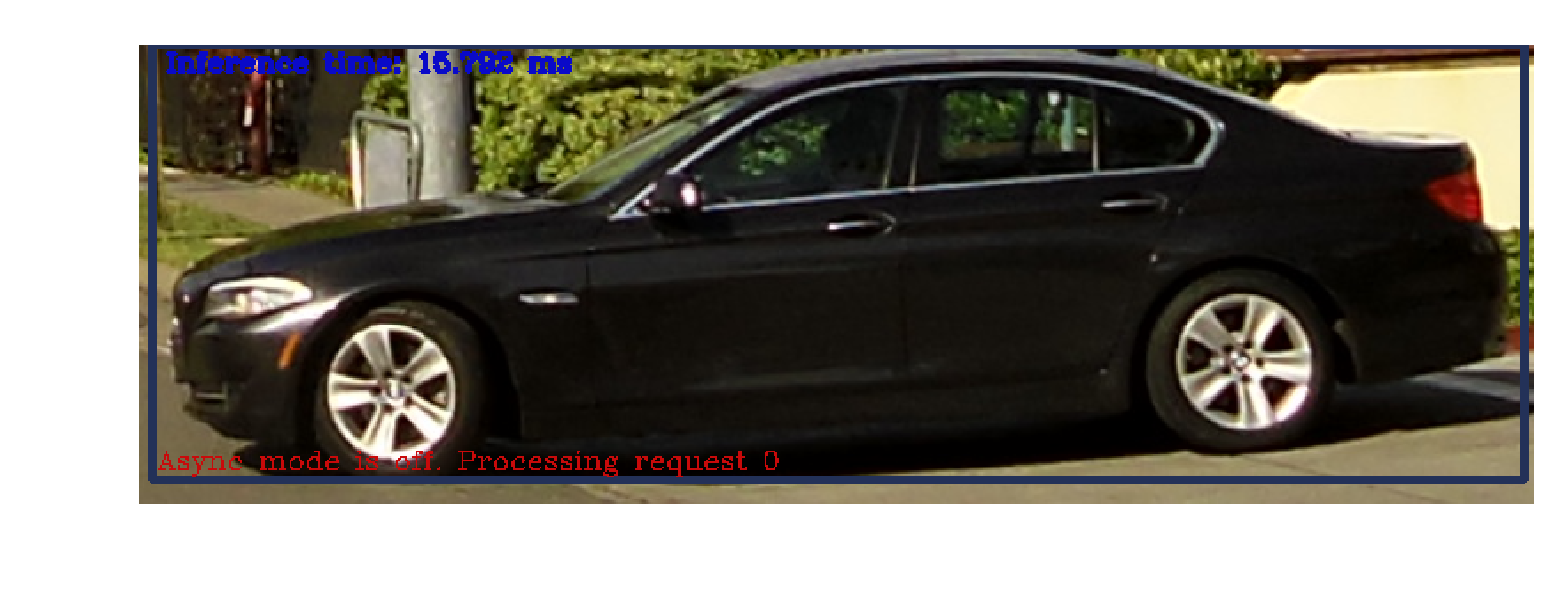

In [10]:
hetero_objects = runInference(hetero_device = 'HETERO:CPU,GPU',
                              model_xml='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP16/mobilenet-ssd.xml',
                              model_bin='/home/intel/openvino_models/models/object_detection/common/mobilenet-ssd/FP16/mobilenet-ssd.bin',
                              image_file='images/car.png',
                              performance_counters = False)

In [11]:
# Get the exec net
exec_net = hetero_objects[2]

# Print the performance counteres
perf_counts = exec_net.requests[0].get_perf_counts()
print("Performance counters:")
for layer, stats in perf_counts.items():
    print(layer, ': ', stats)

Performance counters:
subgraph0: conv13 :  {'layer_type': 'Convolution', 'status': 'EXECUTED', 'cpu_time': 1206, 'real_time': 1206, 'exec_type': 'jit_avx2_1x1_FP32'}
subgraph0: conv13/dw/relu :  {'layer_type': 'ReLU', 'status': 'NOT_RUN', 'cpu_time': 0, 'real_time': 0, 'exec_type': 'undef'}
subgraph0: conv15_2_mbox_priorbox :  {'layer_type': 'PriorBox', 'status': 'NOT_RUN', 'cpu_time': 0, 'real_time': 0, 'exec_type': 'unknown_FP32'}
subgraph0: conv11/relu :  {'layer_type': 'ReLU', 'status': 'NOT_RUN', 'cpu_time': 0, 'real_time': 0, 'exec_type': 'undef'}
subgraph0: conv16_2 :  {'layer_type': 'Convolution', 'status': 'EXECUTED', 'cpu_time': 85, 'real_time': 85, 'exec_type': 'jit_avx2_FP32'}
subgraph0: conv13_mbox_conf_flat :  {'layer_type': 'Flatten', 'status': 'NOT_RUN', 'cpu_time': 0, 'real_time': 0, 'exec_type': 'unknown_FP32'}
subgraph0: conv13_mbox_loc_flat___mbox_loc :  {'layer_type': 'Reorder', 'status': 'EXECUTED', 'cpu_time': 5, 'real_time': 5, 'exec_type': 'reorder_FP32'}
subgr

# Part 4 - Custom Layers

This is a replication of https://github.com/intel-iot-devkit/smart-video-workshop/tree/master/custom-layer workshop.

### Custom Layers

Custom layers are NN (Neural Network) layers that are not explicitly supported by a given framework. This tutorial demonstrates how to run inference on topologies featuring custom layers allowing you to plug in your own implementation for existing or completely new layers.

The list of known layers is different for any particular framework. To see the layers supported by the Intel® Distribution of OpenVINO™ toolkit, refer to the Documentation: https://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html#intermediate-representation-notation-catalog 


If your topology contains layers that are not in the list of known layers, the Model Optimizer considers them to be custom.

The Model Optimizer searches for each layer of the input model in the list of known layers before building the model's internal representation, optimizing the model and producing the Intermediate Representation.

Custom Layers implementation workflow in the Intel® Distribution of OpenVINO™ toolkit
When implementing the custom layer in the Intel® Distribution of OpenVINO™ toolkit for your pre-trained model, you will need to add extensions in both the Model Optimizer and the Inference Engine. The following figure shows the work flow for the custom layer implementation. 

![MO Workflow](images/model_optimizer_workflow.png)

### Example custom layer: Hyperbolic Cosine (cosh) function
We showcase custom layer implementation using a simple function; hyperbolic cosine (cosh). It's mathematically represented as:

![COSH](images/cosh_function.gif)

### Extension Generator
This tool generates extension source files with stubs for the core functions. To get the workable extension, you will add your implementation of these functions to the generated files.

## 1 - Install Dependencies

We need to execute all the commands through terminal so before going further, let's open a new terminal `CTRL + ALT + T`

Let's first install the dependencies, copy the below code to terminal to setup `cogapp` package

```bash
sudo pip3 install cogapp
```

## 2 - Create TF Model

Let's navigate to source folder where the resources are placed.

```bash
cd /home/intel/smart-video-workshop/custom-layer/create_tf_model
```

Then, let's build the model.

We create a simple model with a custom cosh layer. The weights are random and untrained, however sufficient for demonstrating Custom Layer conversion.

```bash
mkdir -p tf_model

chmod +x build_cosh_model.py

./build_cosh_model.py tf_model
```

You will see that model file is generated into `tf_model` folder.

```
Model saved in path: tf_model/model.ckpt
```

## 3 - Generate template files using the Extension Generator:
We're using `/home/intel/smart-video-workshop/custom-layer/extgen_output/` as the target extension path:

This will create templates that will be partially replaced by Python* and C++ code for executing the layer.

```bash
mkdir -p /home/intel/smart-video-workshop/custom-layer/extgen_output/

python3 /opt/intel/openvino/deployment_tools/tools/extension_generator/extgen.py new --mo-tf-ext --mo-op --ie-cpu-ext --ie-gpu-ext --output_dir=/home/intel/smart-video-workshop/custom-layer/extgen_output/

```

Answer the Model Optimizer extension generator questions as follows:

```bash
Please enter layer name:
[Cosh]

Do you want to automatically parse all parameters from model file...
[n]

Please enter all parameters in format...
When you finish please enter 'q'
[q]

Do you want to change any answer (y/n) ?
[n]

Please enter operation name:
[Cosh]

Please input all attributes that should be output in IR...
...
When you finish enter 'q'
[q]

Please input all internal attributes for your operation...
...
When you finish enter 'q'
[q]

Does your operation change shape? (y/n)
[n]

Do you want to change any answer (y/n) ?
[n]

Please enter operation name:
[Cosh]

Please enter all parameters in format...
...
When you finish please enter 'q'
[q]

Do you want to change any answer (y/n) ?
[n]

Please enter operation name:
[Cosh]

Please enter all parameters in format...
...
When you finish please enter 'q'
[q]

Do you want to change any answer (y/n) ?
[n]

```

Output will be like below:

```bash
Stub file for TensorFlow Model Optimizer extractor is in /home/intel/smart-video-workshop/custom-layer/extgen_output/user_mo_extensions/front/tf folder
Stub file for Model Optimizer operation is in /home/intel/smart-video-workshop/custom-layer/extgen_output/./user_mo_extensions/ops folder
Stub files for Inference Engine CPU extension are in /home/intel/smart-video-workshop/custom-layer/extgen_output/./user_ie_extensions/cpu folder
Stub files for Inference Engine GPU extension are in /home/intel/smart-video-workshop/custom-layer/extgen_output/./user_ie_extensions/gpu folder
```

## 4 - Register custom layer for the Model Optimizer

Add Custom (cosh) Python Layers: Copy to the Model Optimizer Ops Directory:

This allows the Model Optimizer to find the Python implementation of cosh.

```bash
sudo cp /home/intel/smart-video-workshop/custom-layer/cosh.py /opt/intel/openvino/deployment_tools/model_optimizer/mo/ops/
```

## 5 - Generate IR with custom layer using Model Optimizer
We run the Model Optimizer for TensorFlow to convert and optimize the new model for the Intel® Distribution of OpenVINO™ toolkit. We explicitly set the batch to 1 because the model has an input dim of "-1". TensorFlow allows "-1" as a variable indicating "to be filled in later", but the Model Optimizer requires explicit information for the optimization process. The output is the full name of the final output layer.

```bash
cd tf_model

mkdir -p /home/intel/smart-video-workshop/custom-layer/cl_ext_cosh

python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py --input_meta_graph model.ckpt.meta --batch 1 --output "ModCosh/Activation_8/softmax_output" --extensions /home/intel/smart-video-workshop/custom-layer/extgen_output/user_mo_extensions --output_dir /home/intel/smart-video-workshop/custom-layer/create_tf_model/tf_model
```

## 6 - Inference Engine custom layer implementation for the Intel® CPU

### Copy CPU and GPU source code to the Model Optimizer extensions directory:

This will be used for building a back-end library for applications that implement cosh.

```bash
cp /home/intel/smart-video-workshop/custom-layer/ext_cosh.cpp /home/intel/smart-video-workshop/custom-layer/extgen_output/user_ie_extensions/cpu/
```

### Compile the C++ extension library:
Here we're building the back-end C++ library to be used by the Inference Engine for executing the cosh layer.

**Note**: Make sure you changed line in CMakeLists.txt 

***
/opt/intel/openvino_2019.1.094/deployment_tools/inference_engine/external/tbb/include
***

to

***
/opt/intel/openvino/deployment_tools/inference_engine/external/tbb/include
***

```bash
cd /home/intel/smart-video-workshop/custom-layer/extgen_output/user_ie_extensions/cpu

cp /home/intel/smart-video-workshop/custom-layer/CMakeLists.txt .

mkdir -p build && cd build

cmake ..

make -j$(nproc)

cp libcosh_cpu_extension.so /home/intel/smart-video-workshop/custom-layer/cl_ext_cosh
```

## 7 - Run Sample Code

#### Using a C++ Sample:

```bash
/home/intel/inference_engine_samples_build/intel64/Release/classification_sample -i /opt/intel/openvino/deployment_tools/demo/car.png -m /home/intel/smart-video-workshop/custom-layer/create_tf_model/tf_model/model.ckpt.xml -d CPU -l /home/intel/smart-video-workshop/custom-layer/cl_ext_cosh/libcosh_cpu_extension.so
```

#### Using a Python Sample:

Prep: Install the OpenCV library and copy an appropriate sample to your home directory for ease of use:

Try running the Python Sample without including the cosh extension library. 

You should see the error describing unsupported Cosh operation.

```bash
python3 /opt/intel/openvino/deployment_tools/inference_engine/samples/python_samples/classification_sample/classification_sample.py -i /opt/intel/openvino/deployment_tools/demo/car.png  -m /home/intel/smart-video-workshop/custom-layer/create_tf_model/tf_model/model.ckpt.xml -d CPU
```

Error Output:
***
```
[ INFO ] Loading network files:
	/home/intel/smart-video-workshop/custom-layer/create_tf_model/tf_model/model.ckpt.xml
	/home/intel/smart-video-workshop/custom-layer/create_tf_model/tf_model/model.ckpt.bin
[ ERROR ] Following layers are not supported by the plugin for specified device CPU:
 ModCosh/cosh/Cosh, ModCosh/cosh_1/Cosh, ModCosh/cosh_2/Cosh
[ ERROR ] Please try to specify cpu extensions library path in sample's command line parameters using -l or --cpu_extension command line argument
```
***

- Now run the command with the cosh extension library:

```
python3 /opt/intel/openvino/deployment_tools/inference_engine/samples/python_samples/classification_sample/classification_sample.py -i /opt/intel/openvino/deployment_tools/demo/car.png  -m /home/intel/smart-video-workshop/custom-layer/create_tf_model/tf_model/model.ckpt.xml -l /home/intel/smart-video-workshop/custom-layer/cl_ext_cosh/libcosh_cpu_extension.so -d CPU
```